## Polymer Project: 
## Implementation of the pivot algorithm to simulate Self-avoiding-random walks

 Names: Mandus Aldag, Alexandros Mylanos

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import time
from tqdm import tqdm


In [3]:
def check_self_avoidance(coords, pivot = None):
    # False = Self avoidant
    # True = not Self avoidant

    if pivot == None:
        N = np.size(coords, axis=1)
        hashset = set()
        for i in range(N):
            tmp_tuple = tuple(coords[:,i])
            if tmp_tuple in hashset:
                return True
            else:
                hashset.add(tmp_tuple)
                
        
        return False
    
    else:
        N = np.size(coords, axis=1)
        if pivot >= N//2:
            longer_site= pivot 
            shorter_site= N-pivot-1
            dir = -1
        else:
            longer_site = N-pivot-1
            shorter_site = pivot
            dir = 1
       
        hashset=set()
        for i in range(1,longer_site+1):
            if i > shorter_site:   # Case when we scan only in the longer direction from the pivot because the short direction was already fully scanned
                tmp_tuple = tuple(coords[:,pivot+i*dir])
                if tmp_tuple in hashset:
                    return True
                else:
                    hashset.add(tmp_tuple)
            else: # Check in both directions of the pivot
                tmp_tuple = tuple(coords[:,pivot+i])
                if tmp_tuple in hashset:
                    return True
                else: 
                    hashset.add(tmp_tuple)
                tmp_tuple = tuple(coords[:,pivot-i])
                if tmp_tuple in hashset:
                    return True
                else: 
                    hashset.add(tmp_tuple)
        return False
                    

In [4]:
def generate_random_walk(L):
    coord = np.zeros((2,L),dtype=int)
    for l in range(1,L):
        direction = np.random.randint(0,4) # clock wise starting from the top
        if direction == 0:
            coord[0,l] = coord[0,l-1]
            coord[1,l] = coord[1,l-1]+1 

        elif  direction == 1:
            coord[0,l] = coord[0,l-1]+1
            coord[1,l] = coord[1,l-1]
        
        elif  direction == 2:
            coord[0,l] = coord[0,l-1]
            coord[1,l] = coord[1,l-1]-1

        elif  direction == 3:
            coord[0,l] = coord[0,l-1]-1
            coord[1,l] =  coord[1,l-1]
    
    return coord
        

In [5]:
def initial_SAW(N: int): #Dimerisation
    if N <= 5:
        tmp = True
        while tmp:
            walk = generate_random_walk(N)
            tmp = check_self_avoidance(walk)
        return walk



    else:
        tmp = True
        while tmp:
            first = initial_SAW(N//2)
            second = initial_SAW(N-N//2+1)
            translated = (first[:,-1]+second.T).T
            concatenated = np.concatenate((first,translated[:,1:]),axis=1)
            tmp = check_self_avoidance(concatenated)

        return concatenated


In [7]:
def initial_SAW_rod(N: int):
    coord = np.zeros((2,N),dtype=int)
    for i in range(N):
        coord[0,i] = i
    return coord


In [8]:
def symmetry_op(coord):
    N = np.size(coord,axis=1)
    g = np.random.randint(0,7)
    if g==0: #+90°(mathematically)
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,-1],[1,0]]), coord[:,i])
    elif g==1: #-90°(mathematically)
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,1],[-1,0]]), coord[:,i])
    elif g==2: #180°
        for i in range(N):
            coord[:,i] = np.dot(np.array([[-1,0],[0,-1]]), coord[:,i])
    elif g==3: #x-axis symmetry
        for i in range(N):
            coord[:,i] = np.dot(np.array([[1,0],[0,-1]]), coord[:,i])
    elif g==4: #y-axis symmetry
        for i in range(N):
            coord[:,i] = np.dot(np.array([[-1,0],[0,1]]), coord[:,i])
    elif g==5: #diagonal reflection upperright-bottomleft
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,1],[1,0]]), coord[:,i])
    elif g==6: #diagonal reflection upperleft-bottomright
        for i in range(N):
            coord[:,i] = np.dot(np.array([[0,-1],[-1,0]]), coord[:,i])
    if debug:
        print("g = ",g)
    return coord, g
    

In [9]:
def pivot_step(coord):
    global accepted
    N = np.size(coord,axis=1)
    pivot = np.random.randint(1,N)
    if debug:
        print("pivot = ",pivot)
    to_be_operated = coord[:,pivot:]
    to_be_operated = (to_be_operated.T-to_be_operated[:,0]).T
    operated, g = symmetry_op(to_be_operated)
    accepted[1,g] +=1
    operated = (operated.T+coord[:,pivot]).T

    coord_new = np.concatenate((coord[:,:pivot],operated),axis=1)
    not_selfavoidant = check_self_avoidance(coord_new,pivot)
    if not_selfavoidant:
        if debug:
            print("Not selfavoidant")
        return coord
    else:
        accepted[0,g] +=1
        return coord_new


In [10]:
def squared_end_to_end(coord):
    return np.linalg.norm(coord[:,-1])**2

def squared_gyration(coord):
    N = np.size(coord,axis=1)
    a = (1/N * np.sum(coord,axis=1))
    inbracket = np.dot(a,a)
    result = 0
    for i in range(N):
        result += np.dot(coord[:,i], coord[:,i])-inbracket
    return 1/N * result

In [11]:
def pivot_run(coord,iterations):
    global accepted
    ω_squared = []
    S_squared = []
    for i in tqdm(range(iterations)):
        coord = pivot_step(coord)
        ω_squared.append(squared_end_to_end(coord))
        S_squared.append(squared_gyration(coord))
    return ω_squared, S_squared, accepted

In [12]:
def autocorrelation(timeseries, mean=None):
    timeseries = np.array(timeseries)
    if mean is None:
        mean = timeseries.mean()
    fluctuations = timeseries-mean

    C = np.fft.ifft(np.fft.fft(fluctuations) * np.fft.ifft(fluctuations)).real
    return C/C[0]

def integrated_autocorrelation_time(timeseries, mean=None, until=None):
    steps = len(timeseries)
    if until is None:
        until = steps // 2
    Gamma = autocorrelation(timeseries, mean=mean)[:until]
    try:
        first_zero = np.where(Gamma <= 0)[0][0]
        print("First zero = ",first_zero)
        return 0.5 + Gamma[1:first_zero].sum()
    except:
        # Gamma never hits 0.  So the autocorrelation spans ~ the whole ensemble.
        return steps # at least!

In [13]:
def binning_analyis(data,kmax):
    M = len(data)
    error_est = []
    for k in range(1,kmax+1):
        M_k = M//k
        X_k = np.mean(np.reshape(data[:M_k*k],(-1,k)).T,axis=0)
        #print(len(X_k))
        error_est.append(np.std(X_k)/np.sqrt(M_k))
    τ = 0.5*((error_est[-1]/error_est[0])**2-1)
    return error_est, int(np.ceil(τ))

# Check if a pivot step works:

pivot =  2
g =  1
5.000000000000001


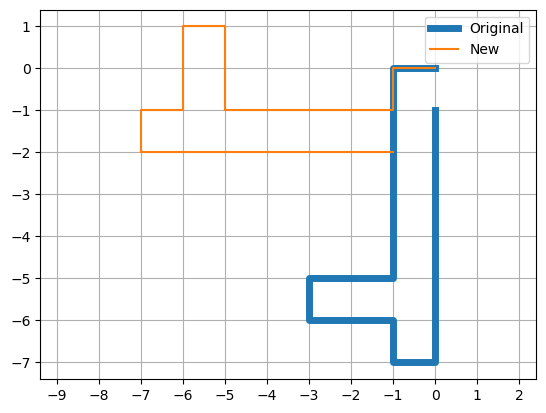

In [15]:
test = initial_SAW(20)
debug = 1
accepted = np.zeros((2,7))
plt.plot(test[0,:],test[1,:],linewidth=5,label="Original")
new = pivot_step(test)
print(squared_end_to_end(new))
plt.plot(new[0,:],new[1,:],label="New")
ax = plt.gca() 
ax.xaxis.set_major_locator(MultipleLocator(1))  # X ticks every 1 unit
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.axis("equal")
plt.legend()
plt.grid()
plt.show()

# Preliminary Tests

# N = 16

In [ ]:
np.random.seed(4321)
iterations = 10**7
N=16
coord = initial_SAW(N)
accepted = np.zeros((2,7))
debug = 0
ω_squared, S_squared, accepted = pivot_run(coord,iterations)
f = np.sum(accepted[0,:])/np.sum(accepted[1,:])
f_ops = accepted[0,:]/accepted[1,:]

100%|██████████| 10000000/10000000 [06:47<00:00, 24569.21it/s]

0.5810395


Error analysis and results:

In [18]:
error_ω_squared,τ_int_bin_ω_squared  = binning_analyis(ω_squared,300)
error_S_squared,τ_int_bin_S_squared  = binning_analyis(S_squared,300)
mean_ω_squared = np.mean(ω_squared)
mean_S_squared = np.mean(S_squared)
ur = mean_S_squared/mean_ω_squared


print(f"Mean squared end-to-end distance is: {mean_ω_squared} ± {error_ω_squared[-1]}")
print(f"Mean squared gyration radius is: {mean_S_squared} ± {error_S_squared[-1]}")
print(f"Universal ratio is: {ur}")
print(f"Acceptance rate f = ",f)
print(f"Autocorrelation time ω^2= ",τ_int_bin_ω_squared)
print(f"Autocorrelation time S^2= ",τ_int_bin_S_squared )

Mean squared end-to-end distance is: 47.1933868 ± 0.026909941028947088
Mean squared gyration radius is: 6.7844908109375 ± 0.00265304030574153
Universal ratio is: 0.14375935424362254
Acceptance rate f =  0.5810395
Autocorrelation time ω^2=  4
Autocorrelation time S^2=  7


# N=20

In [ ]:
np.random.seed(1234)
iterations = 10**7
N=21
coord = initial_SAW(N)
accepted = np.zeros((2,7))
debug = 0
ω_squared, S_squared, accepted = pivot_run(coord,iterations)
f = np.sum(accepted[0,:])/np.sum(accepted[1,:])
f_ops = accepted[0,:]/accepted[1,:]

100%|██████████| 10000000/10000000 [08:17<00:00, 20112.65it/s]


0.5487302


In [ ]:

error_ω_squared,τ_int_bin_ω_squared  = binning_analyis(ω_squared,300)
error_S_squared,τ_int_bin_S_squared  = binning_analyis(S_squared,300)
mean_ω_squared = np.mean(ω_squared)
mean_S_squared = np.mean(S_squared)
ur = mean_S_squared/mean_ω_squared

print(f"Mean squared end-to-end distance is: {mean_ω_squared} ± {error_ω_squared[-1]}")
print(f"Mean squared gyration radius is: {mean_S_squared} ± {error_S_squared[-1]}")
print(f"Universal ratio is: {ur}")
print(f"Acceptance rate f = ",f)
print(f"Autocorrelation time ω^2= ",τ_int_bin_ω_squared)
print(f"Autocorrelation time S^2= ",τ_int_bin_S_squared )

Mean squared end-to-end distance is: 72.0007204 ± 0.04412505568238656
Mean squared gyration radius is: 10.239910732426322 ± 0.004485764343457121
Universal ratio is: 0.14221955940910727
Acceptance rate f =  0.5487302
Autocorrelation time ω^2=  5
Autocorrelation time S^2=  8


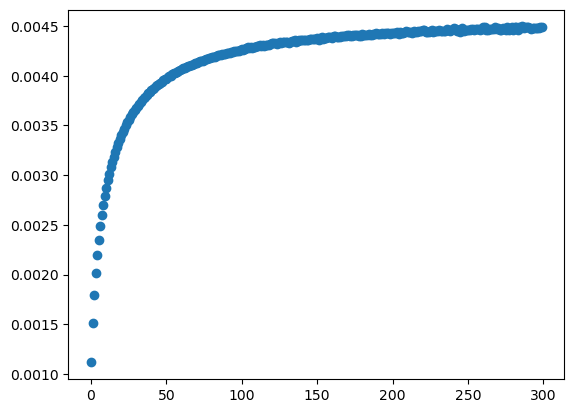

In [25]:
plt.scatter(range(300),error_S_squared)

# Simulations

The simulations with Ns = [101,201,401,601,801,1001,1201,1401,1601,2001,2401,3001,4001] are done using a dimerisation start, therefore we don't need a thermalisation. 
The simulations with Ns = [5001, 6001, 7001, 8001, 9001, 10001] have a rod start and therefore the first 10**5 configurations get discarded as thermalisation.




With dimerisation start:

In [ ]:
Ns = [101,201,401,601,801,1001,1201,1401,1601,2001,2401,3001,4001] #with dimerisation
seeds = np.array([2781300983, 552437507, 239163331, 1112836520, 1562221245, 4039863786,  930428319, 4185896816, 2716273418, 4265127893, 432287740, 2672218962, 3546297565])

iterations = 10**6
binning_max = 5000
times = np.zeros((2,len(Ns)))
ω_squareds = np.zeros((len(Ns),iterations))
S_squareds = np.zeros((len(Ns),iterations))
error_ω_squareds = np.zeros((len(Ns),binning_max))
error_S_squareds = np.zeros((len(Ns),binning_max))
autocorr_time_ω_squareds = np.zeros(len(Ns))
autocorr_time_S_squareds = np.zeros(len(Ns))
debug = 0

for i,N in enumerate(Ns):
    print("N = ",N)
    np.random.seed(seeds[i])
    accepted = np.zeros((2,7))
    start = time.time()
    coord = initial_SAW(N)
    end = time.time()
    ω_squared, S_squared, accepted = pivot_run(coord,iterations)
    end_total = time.time()
    ω_squareds[i,:] = ω_squared
    S_squareds[i,:] = S_squared

    times[0,i] = end-start
    times[1,i] = end_total-start

    np.save(f"results_dimerisation/accepted{N}.npy",accepted)


    error_ω_squared, autocorr_time_ω_squared = binning_analyis(ω_squared,binning_max)
    error_S_squared, autocorr_time_S_squared = binning_analyis(S_squared,binning_max)
    error_ω_squareds[i,:] = error_ω_squared
    error_S_squareds[i,:] = error_S_squared
    autocorr_time_ω_squareds[i] = autocorr_time_ω_squared
    autocorr_time_S_squareds[i] = autocorr_time_S_squared
    

    plt.xlabel("Binning level")
    plt.ylabel("Error")
    plt.grid()
    plt.scatter(range(binning_max),error_ω_squared,label="Squared end-to-end distance")
    plt.scatter(range(binning_max),error_S_squared,label="Squared radius of gyration")
    plt.legend()
    plt.savefig(f"results_dimerisation/Binning_analysis{N}.png")
    plt.close()


np.save("results_dimerisation/ω_squareds.npy",ω_squareds)
np.save("results_dimerisation/S_squareds.npy",S_squareds)
np.save("results_dimerisation/times.npy",times)
np.save("results_dimerisation/error_ω_squareds.npy",error_ω_squareds)
np.save("results_dimerisation/error_S_squareds.npy",error_S_squareds)
np.save("results_dimerisation/autocorr_time_ω_squared.npy",autocorr_time_ω_squareds)
np.save("results_dimerisation/autocorr_time_S_squared.npy",autocorr_time_S_squareds)


With thermalisation start:

In [ ]:

Ns = [5001, 6001, 7001, 8001, 9001, 10001]
seeds = np.array([2553958265, 4001684326, 2857604770, 1481844885, 2013886044, 3609482437])  #with thermalisation

iterations = 10**6 + 10**5
binning_max = 5000
times = np.zeros((2,len(Ns)))
ω_squareds = np.zeros((len(Ns),iterations))
S_squareds = np.zeros((len(Ns),iterations))
error_ω_squareds = np.zeros((len(Ns),binning_max))
error_S_squareds = np.zeros((len(Ns),binning_max))
autocorr_time_ω_squareds = np.zeros(len(Ns))
autocorr_time_S_squareds = np.zeros(len(Ns))
debug = 0

for i,N in enumerate(Ns):
    print("N = ",N)
    np.random.seed(seeds[i])
    accepted = np.zeros((2,7))
    start = time.time()
    coord = initial_SAW_rod(N)
    end = time.time()
    ω_squared, S_squared, accepted = pivot_run(coord,iterations)
    end_total = time.time()
    ω_squareds[i,:] = ω_squared
    S_squareds[i,:] = S_squared

    times[0,i] = end-start
    times[1,i] = end_total-start

    np.save(f"results_thermalisation/accepted{N}.npy",accepted)

    #Check if thermalisation is sufficient
    plt.xlabel("Time")
    plt.ylabel("Squared end-to-end distance")
    plt.grid()
    plt.plot(range(10**5),ω_squared[:10**5],label="Squared end-to-end distance")
    plt.legend()
    plt.savefig(f"results_thermalisation/thermalisation/ω_squared_{N}.png")
    plt.close()

    plt.xlabel("Time")
    plt.ylabel("Squared radius of gyration")
    plt.grid()
    plt.plot(range(10**5),S_squared[:10**5],label="Squared radius of gyration")
    plt.legend()
    plt.savefig(f"results_thermalisation/thermalisation/S_squared_{N}.png")
    plt.close()




    error_ω_squared, autocorr_time_ω_squared = binning_analyis(ω_squared[10**5:],binning_max)
    error_S_squared, autocorr_time_S_squared = binning_analyis(S_squared[10**5:],binning_max)
    error_ω_squareds[i,:] = error_ω_squared
    error_S_squareds[i,:] = error_S_squared
    autocorr_time_ω_squareds[i] = autocorr_time_ω_squared
    autocorr_time_S_squareds[i] = autocorr_time_S_squared
    

    plt.xlabel("Binning level")
    plt.ylabel("Error")
    plt.grid()
    plt.scatter(range(binning_max),error_ω_squared,label="Squared end-to-end distance")
    plt.scatter(range(binning_max),error_S_squared,label="Squared radius of gyration")
    plt.legend()
    plt.savefig(f"results_thermalisation/Binning_analysis{N}.png")
    plt.close()


np.save("results_thermalisation/ω_squareds.npy",ω_squareds)
np.save("results_thermalisation/S_squareds.npy",S_squareds)
np.save("results_thermalisation/times.npy",times)
np.save("results_thermalisation/error_ω_squareds.npy",error_ω_squareds)
np.save("results_thermalisation/error_S_squareds.npy",error_S_squareds)
np.save("results_thermalisation/autocorr_time_ω_squared.npy",autocorr_time_ω_squareds)
np.save("results_thermalisation/autocorr_time_S_squared.npy",autocorr_time_S_squareds)


# Results and Analysis

In [134]:
Ns = [101,201,401,601,801,1001,1201,1401,1601,2001,2401,3001,4001,5001,6001,7001,8001,9001,10001]
#Ns = [101,201,401,601,801,1001,1201,1401,1601,2001,2401,3001,4001]

ω_squareds = np.concatenate((np.load("results_dimerisation/ω_squareds.npy"), np.load("results_thermalisation/ω_squareds.npy")[:,10**5:]))
S_squareds = np.concatenate((np.load("results_dimerisation/S_squareds.npy"), np.load("results_thermalisation/S_squareds.npy")[:,10**5:]))

error_ω_squareds = np.concatenate((np.load("results_dimerisation/error_ω_squareds.npy"), np.load("results_thermalisation/error_ω_squareds.npy")))
error_S_squareds = np.concatenate((np.load("results_dimerisation/error_S_squareds.npy"), np.load("results_thermalisation/error_S_squareds.npy")))

autocorr_time_ω_squareds = np.concatenate((np.load("results_dimerisation/autocorr_time_ω_squareds.npy") , np.load("results_thermalisation/autocorr_time_ω_squareds.npy")))
autocorr_time_S_squareds = np.concatenate((np.load("results_dimerisation/autocorr_time_S_squareds.npy") , np.load("results_thermalisation/autocorr_time_S_squareds.npy")))

autocorr_time_error_ω_squareds = np.concatenate((np.load("results_dimerisation/autocorr_time_error_ω_squareds.npy") , np.load("results_thermalisation/autocorr_time_error_ω_squareds.npy")))
autocorr_time_error_S_squareds = np.concatenate((np.load("results_dimerisation/autocorr_time_error_S_squareds.npy") , np.load("results_thermalisation/autocorr_time_error_S_squareds.npy")))

times = np.concatenate((np.load("results_dimerisation/times.npy"),np.load("results_thermalisation/times.npy")),axis=1)
mean_ω_squareds=[]
mean_S_squareds=[]
fs = []
for i,N in enumerate(Ns):
    ω_squared = ω_squareds[i,:]
    S_squared = S_squareds[i,:]
    #error_ω_squared = error_ω_squareds[i,:]
    #error_S_squared = error_S_squareds[i,:]
    autocorr_time_ω_squared = autocorr_time_ω_squareds[i]
    autocorr_time_S_squared = autocorr_time_S_squareds[i]

    mean_ω_squared = np.mean(ω_squared)
    mean_ω_squareds.append(mean_ω_squared)
    mean_S_squared = np.mean(S_squared)
    mean_S_squareds.append(mean_S_squared)

    ur = mean_S_squared/mean_ω_squared
    
    if N <= 4001:
        accepted = np.load(f"results_dimerisation/accepted{N}.npy")
    else:
         accepted = np.load(f"results_thermalisation/accepted{N}.npy")

    f = np.sum(accepted[0,:])/np.sum(accepted[1,:])
    fs.append(f)
    


    print(f"Results for N = {N}:")
    print(f"Mean squared end-to-end distance is: {mean_ω_squared:.3f} ± {error_ω_squareds[i]:.3f}")
    print(f"Mean squared gyration radius is: {mean_S_squared:.3f} ± {error_S_squareds[i]:.3f}")
    print(f"Universal ratio ur = {ur:.3f}")
    print(f"Acceptance rate f = {f:.6f}")
    print(f"Autocorrelation time ω^2 = {autocorr_time_ω_squared:.3f} ± {autocorr_time_error_ω_squareds[i]:.3f}")
    print(f"Autocorrelation time S^2 = {autocorr_time_S_squared:.3f} ± {autocorr_time_error_S_squareds[i]:.3f}")
    print(f"Total simulation time [s] = {times[1,i]:.3f}")
    print(f"From that: Dimerisation time [s] = {times[0,i]:.3f}")
    print()
          

Results for N = 101:
Mean squared end-to-end distance is: 779.532 ± 2.254
Mean squared gyration radius is: 109.209 ± 0.253
Universal ratio ur = 0.140
Acceptance rate f = 0.398538
Autocorrelation time ω^2 = 9.056 ± 0.612
Autocorrelation time S^2 = 18.655 ± 1.193
Total simulation time [s] = 392.278
From that: Dimerisation time [s] = 0.137

Results for N = 201:
Mean squared end-to-end distance is: 2184.677 ± 7.354
Mean squared gyration radius is: 306.216 ± 0.886
Universal ratio ur = 0.140
Acceptance rate f = 0.347684
Autocorrelation time ω^2 = 12.438 ± 0.833
Autocorrelation time S^2 = 28.769 ± 1.736
Total simulation time [s] = 749.902
From that: Dimerisation time [s] = 0.653

Results for N = 401:
Mean squared end-to-end distance is: 6163.315 ± 21.573
Mean squared gyration radius is: 867.114 ± 2.700
Universal ratio ur = 0.141
Acceptance rate f = 0.303647
Autocorrelation time ω^2 = 13.238 ± 0.949
Autocorrelation time S^2 = 33.067 ± 2.037
Total simulation time [s] = 1487.128
From that: Dimer

This error_analysis function is used to calculate the standard error and the error of the autocorrelation times. For this one manually does a binning analyis for each simulation until convergence. Because in "convergence" the error still fluctuates one takes the mean of the error in the region of convergence as the standard error and uses its standard deviation as to calculate the error of the autocorrelation time (via error proagation)

In [ ]:
# def error_analysis(errors, boundary):
#     mean_error = np.mean(errors[boundary:])
#     τ = 0.5*((mean_error/errors[0])**2-1)
#     std_error = np.std(errors[boundary:])
#     τ_error = std_error*mean_error/errors[0]**2

#     return mean_error, τ, τ_error

# initial = 0
# if initial:
    
#     error_ω_squareds = np.array([])
#     error_S_squareds = np.array([])
#     autocorr_time_ω_squareds = np.array([])
#     autocorr_time_error_ω_squareds = np.array([])
#     autocorr_time_S_squareds = np.array([])
#     autocorr_time_error_S_squareds = np.array([])

#     np.save("binning_thermalisation/error_ω_squareds.npy",error_ω_squareds)
#     np.save("binning_thermalisation/error_S_squareds.npy",error_S_squareds)
#     np.save("binning_thermalisation/autocorr_time_ω_squareds.npy",autocorr_time_ω_squareds)
#     np.save("binning_thermalisation/autocorr_time_S_squareds.npy",autocorr_time_S_squareds)
#     np.save("binning_thermalisation/autocorr_time_error_ω_squareds.npy",autocorr_time_error_ω_squareds)
#     np.save("binning_thermalisation/autocorr_time_error_S_squareds.npy",autocorr_time_error_S_squareds)
# else:
#     Ns = [5001, 6001, 7001, 8001, 9001, 10001] 
#     error_ω_squareds = np.load("binning_thermalisation/error_ω_squareds.npy")
#     error_S_squareds = np.load("binning_thermalisation/error_S_squareds.npy")
#     autocorr_time_ω_squareds = np.load("binning_thermalisation/autocorr_time_ω_squareds.npy")
#     autocorr_time_error_ω_squareds = np.load("binning_thermalisation/autocorr_time_error_ω_squareds.npy")
#     autocorr_time_S_squareds = np.load("binning_thermalisation/autocorr_time_S_squareds.npy")
#     autocorr_time_error_S_squareds = np.load("binning_thermalisation/autocorr_time_error_S_squareds.npy")

#     i = 5
#     N = Ns[i]
#     binning_max = 80000
#     ω_squared = np.load("results_thermalisation/ω_squareds.npy")[i,10**5:]
#     S_squared = np.load("results_thermalisation/S_squareds.npy")[i,10**5:]
#     error_ω_squared = binning_analyis(ω_squared,binning_max)[0]
#     error_S_squared = binning_analyis(S_squared,binning_max)[0]

#     do = 0
#     if do:
#         print(f" N = {N}")
#         mean_error, τ, τ_error = error_analysis(error_ω_squared,60000)
#         error_ω_squareds = np.append(error_ω_squareds,mean_error)
#         autocorr_time_ω_squareds = np.append(autocorr_time_ω_squareds,τ)
#         autocorr_time_error_ω_squareds = np.append(autocorr_time_error_ω_squareds,τ_error)
    
#         mean_error, τ, τ_error = error_analysis(error_S_squared,60000)
#         error_S_squareds = np.append(error_S_squareds,mean_error)
#         autocorr_time_S_squareds = np.append(autocorr_time_S_squareds,τ)
#         autocorr_time_error_S_squareds = np.append(autocorr_time_error_S_squareds,τ_error)

#     plt.xlabel("Binning level")
#     plt.ylabel("Error")
#     plt.grid()
#     plt.scatter(range(binning_max),error_ω_squared,label="Squared end-to-end distance")
#     plt.scatter(range(binning_max),error_S_squared,label="Squared radius of gyration")
#     plt.legend()
#     plt.savefig(f"binning_thermalisation/Binning_analysis{N}.png")
#     plt.close()

#     np.save("binning_thermalisation/error_ω_squareds.npy",error_ω_squareds)
#     np.save("binning_thermalisation/error_S_squareds.npy",error_S_squareds)
#     np.save("binning_thermalisation/autocorr_time_ω_squareds.npy",autocorr_time_ω_squareds)
#     np.save("binning_thermalisation/autocorr_time_S_squareds.npy",autocorr_time_S_squareds)
#     np.save("binning_thermalisation/autocorr_time_error_ω_squareds.npy",autocorr_time_error_ω_squareds)
#     np.save("binning_thermalisation/autocorr_time_error_S_squareds.npy",autocorr_time_error_S_squareds)


 N = 10001


In [133]:
error_ω_squareds = np.load("binning_thermalisation/error_ω_squareds.npy")
error_S_squareds = np.load("binning_thermalisation/error_S_squareds.npy")
autocorr_time_ω_squareds = np.load("binning_thermalisation/autocorr_time_ω_squareds.npy")
autocorr_time_error_ω_squareds = np.load("binning_thermalisation/autocorr_time_error_ω_squareds.npy")
autocorr_time_S_squareds = np.load("binning_thermalisation/autocorr_time_S_squareds.npy")
autocorr_time_error_S_squareds = np.load("binning_thermalisation/autocorr_time_error_S_squareds.npy")
#print(error_ω_squareds)
#print(error_S_squareds)
print(autocorr_time_S_squareds)
print(autocorr_time_error_S_squareds)

[ 65.97669833  69.08975173  88.96983725  64.59043057  98.1626905
 152.99340828]
[ 3.56346011  4.61948312  7.21861616  2.74251716  8.33951585 21.43206912]


# Critical Exponents

In [146]:
def polynomial(x,a,b):
    return a*x**b
from scipy.optimize import curve_fit
poptf, pcovf = curve_fit(polynomial, Ns, fs)
poptω_squareds, pcovω_squareds = curve_fit(polynomial, Ns, mean_ω_squareds, sigma=error_ω_squareds,absolute_sigma=True)
poptS_squareds, pcovS_squareds = curve_fit(polynomial, Ns, mean_S_squareds,sigma=error_S_squareds,absolute_sigma=True)

popt_autocorr_ω, pcov_autcorr_ω = curve_fit(polynomial, Ns, autocorr_time_ω_squareds,sigma = autocorr_time_error_ω_squareds,absolute_sigma=False)
popt_autocorr_S, pcov_autcorr_S = curve_fit(polynomial, Ns, autocorr_time_S_squareds, sigma = autocorr_time_error_S_squareds,absolute_sigma=False)



Critical exponent p = -0.1941 ± 0.0008


/tmp/ipykernel_6275/142219923.py:2: RuntimeWarning: divide by zero encountered in power
  return a*x**b


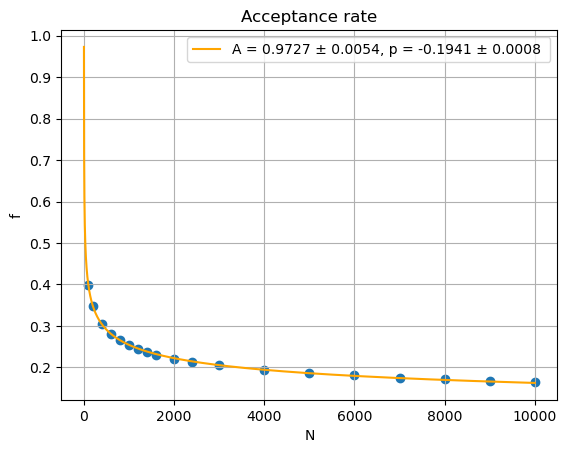

In [136]:
plt.scatter(Ns,fs)
plt.xlabel("N")
plt.ylabel(r"f")
plt.plot(range(10000),polynomial(range(10000),poptf[0],poptf[1]), label=fr'A = {poptf[0]:.4f} ± {np.sqrt(pcovf[0,0]):.4f}, p = {poptf[1]:.4f} ± {np.sqrt(pcovf[1,1]):.4f} ',color="orange")
plt.grid()
plt.title("Acceptance rate")
plt.legend()
print(fr'Critical exponent p = {poptf[1]:.4f} ± {np.sqrt(pcovf[1,1]):.4f}')

Critical exponent $\nu$ = 0.7503 ± 0.0005


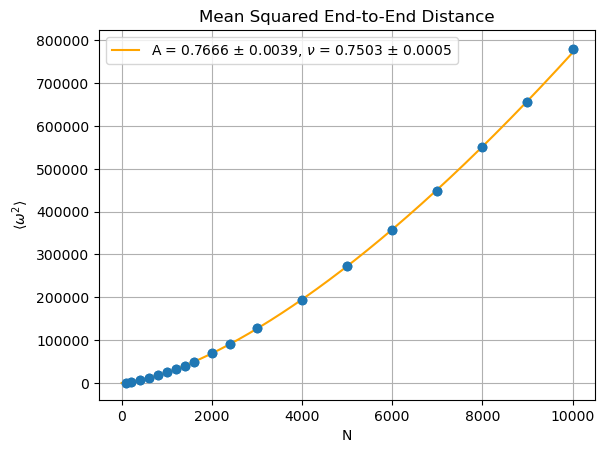

In [137]:
plt.scatter(Ns,mean_ω_squareds)
plt.errorbar(Ns, mean_ω_squareds, yerr=error_ω_squareds, fmt="o")
plt.xlabel("N")
plt.ylabel(r"$\langle \omega^2 \rangle$")
plt.plot(range(10000),polynomial(range(10000),poptω_squareds[0],poptω_squareds[1]), label=fr'A = {poptω_squareds[0]:.4f} ± {np.sqrt(pcovω_squareds[0,0]):.4f}, $\nu$ = {poptω_squareds[1]/2:.4f} ± {np.sqrt(pcovω_squareds[1,1]/2):.4f} ',color="orange")
plt.grid()
plt.title("Mean Squared End-to-End Distance")
plt.legend()
print(fr'Critical exponent $\nu$ = {poptω_squareds[1]/2:.4f} ± {np.sqrt(pcovω_squareds[1,1]/2):.4f}')

In [117]:
residuals = mean_ω_squareds - polynomial(Ns, *poptω_squareds)
chi2 = np.sum((residuals/error_ω_squareds)** 2)
dof = len(Ns) - len(poptω_squareds)
chi2_red = chi2 / dof
chi2_red

1.0251396936540715

Critical exponent $\nu$ = 0.7505 ± 0.0004


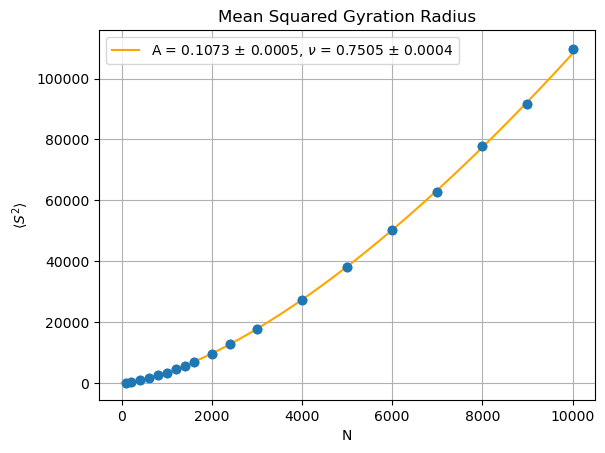

In [138]:
plt.scatter(Ns,mean_S_squareds)
plt.errorbar(Ns, mean_S_squareds, yerr=error_S_squareds, fmt="o")
plt.xlabel("N")
plt.ylabel(r"$\langle S^2 \rangle$")
plt.plot(range(10000),polynomial(range(10000),poptS_squareds[0],poptS_squareds[1]), label=fr'A = {poptS_squareds[0]:.4f} ± {np.sqrt(pcovS_squareds[0,0]):.4f}, $\nu$ = {poptS_squareds[1]/2:.4f} ± {np.sqrt(pcovS_squareds[1,1]/2):.4f} ',color="orange")
plt.grid()
plt.title("Mean Squared Gyration Radius")
plt.legend()
print(fr'Critical exponent $\nu$ = {poptS_squareds[1]/2:.4f} ± {np.sqrt(pcovS_squareds[1,1]/2):.4f}')

In [115]:
residuals = mean_S_squareds - polynomial(Ns, *poptS_squareds)
chi2 = np.sum((residuals/error_S_squareds)** 2)
dof = len(Ns) - len(poptS_squareds)
chi2_red = chi2 / dof
chi2_red

1.706695404004982

In [171]:
exclude = [7,9,18]
popt_autocorr_ω_outlier, pcov_autcorr_ω_outlier= curve_fit(polynomial, np.delete(Ns,exclude),np.delete(autocorr_time_ω_squareds, exclude) ,sigma = np.delete(autocorr_time_error_ω_squareds,exclude),absolute_sigma=False)
popt_autocorr_S_outlier, pcov_autcorr_S_outlier = curve_fit(polynomial, np.delete(Ns,exclude),np.delete(autocorr_time_S_squareds, exclude) ,sigma = np.delete(autocorr_time_error_S_squareds,exclude),absolute_sigma=False)
popt_autocorr_ω_test, pcov_autcorr_ω_test = curve_fit(polynomial, Ns, autocorr_time_ω_squareds)
popt_autocorr_S_test, pcov_autcorr_S_test = curve_fit(polynomial, Ns, autocorr_time_S_squareds)


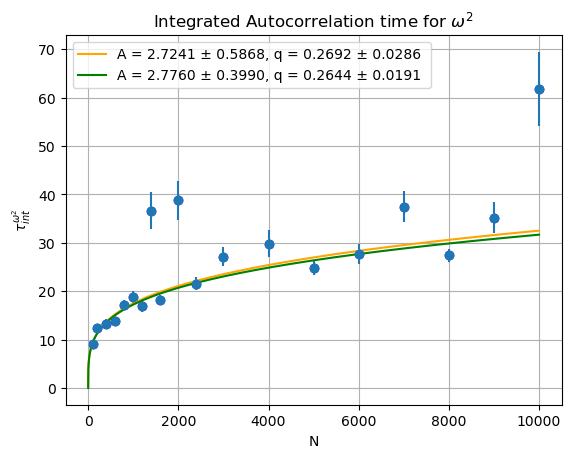

In [174]:
plt.scatter(Ns,autocorr_time_ω_squareds,color = "blue")
plt.errorbar(Ns, autocorr_time_ω_squareds, yerr=autocorr_time_error_ω_squareds, fmt="o")
plt.xlabel("N")
plt.ylabel(r"$\tau^{\omega^2}_{int}$")
plt.plot(range(10000),polynomial(range(10000),popt_autocorr_ω[0],popt_autocorr_ω[1]), label=fr'A = {popt_autocorr_ω[0]:.4f} ± {np.sqrt(pcov_autcorr_ω[0,0]):.4f}, q = {popt_autocorr_ω[1]:.4f} ± {np.sqrt(pcov_autcorr_ω[1,1]):.4f} ',color="orange")
plt.plot(range(10000),polynomial(range(10000),popt_autocorr_ω_outlier[0],popt_autocorr_ω_outlier[1]), label=fr'A = {popt_autocorr_ω_outlier[0]:.4f} ± {np.sqrt(pcov_autcorr_ω_outlier[0,0]):.4f}, q = {popt_autocorr_ω_outlier[1]:.4f} ± {np.sqrt(pcov_autcorr_ω_outlier[1,1]):.4f} ',color="green")
#plt.plot(range(10000),polynomial(range(10000),popt_autocorr_ω_test[0],popt_autocorr_ω_test[1]), label=fr'A = {popt_autocorr_ω_test[0]:.4f} ± {np.sqrt(pcov_autcorr_ω_test[0,0]):.4f}, q = {popt_autocorr_ω_test[1]:.4f} ± {np.sqrt(pcov_autcorr_ω_test[1,1]):.4f} ',color="red")
plt.grid()
plt.title(r"Integrated Autocorrelation time for $ω^2$")
plt.legend(loc=2)
#print(fr'Critical exponent q = {popt_autocorr_ω[1]:.4f} ± {np.sqrt(pcov_autcorr_ω[1,1]):.4f}')

Critical exponent q = 0.2807 ± 0.0269


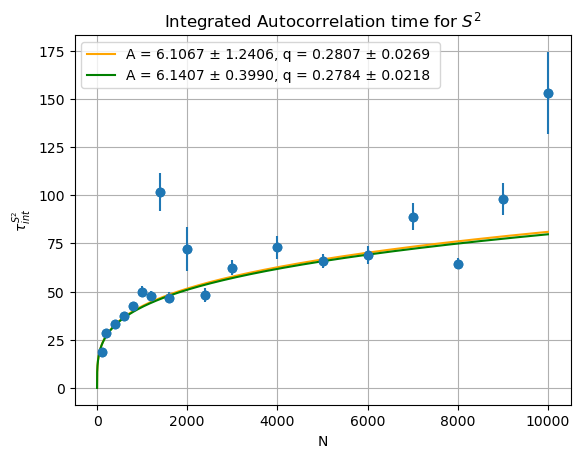

In [160]:
plt.scatter(Ns,autocorr_time_S_squareds)
plt.errorbar(Ns, autocorr_time_S_squareds, yerr=autocorr_time_error_S_squareds, fmt="o")
plt.xlabel("N")
plt.ylabel(r"$\tau^{S^2}_{int}$")
plt.plot(range(10000),polynomial(range(10000),popt_autocorr_S[0],popt_autocorr_S[1]), label=fr'A = {popt_autocorr_S[0]:.4f} ± {np.sqrt(pcov_autcorr_S[0,0]):.4f}, q = {popt_autocorr_S[1]:.4f} ± {np.sqrt(pcov_autcorr_S[1,1]):.4f} ',color="orange")
plt.plot(range(10000),polynomial(range(10000),popt_autocorr_S_outlier[0],popt_autocorr_S_outlier[1]), label=fr'A = {popt_autocorr_S_outlier[0]:.4f} ± {np.sqrt(pcov_autcorr_ω_outlier[0,0]):.4f}, q = {popt_autocorr_S_outlier[1]:.4f} ± {np.sqrt(pcov_autcorr_S_outlier[1,1]):.4f} ',color="green")
plt.grid()
plt.title(r"Integrated Autocorrelation time for $S^2$")
plt.legend(loc=2)
print(fr'Critical exponent q = {popt_autocorr_S[1]:.4f} ± {np.sqrt(pcov_autcorr_S[1,1]):.4f}')

First zero =  1992
First zero =  903
C_time =  141.51525450614403
C1_time =  77.86481777734544


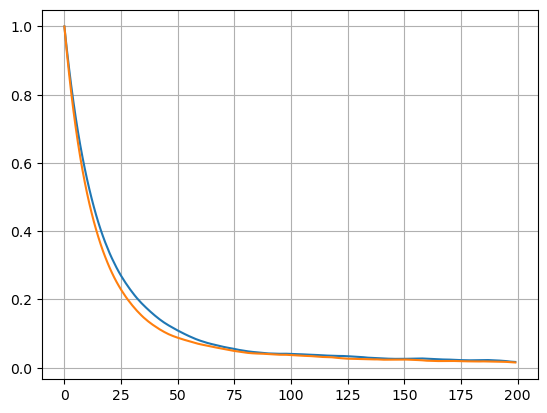

In [ ]:

C = autocorrelation(ω_squareds[-1,:])
C1 = autocorrelation(ω_squareds[13,:])
C_time = integrated_autocorrelation_time(C)
C1_time = integrated_autocorrelation_time(C1)
plt.plot(C[:200]) 
plt.plot(C1[:200])
plt.grid()
print("C_time = ",C_time)
print("C1_time = ",C1_time)
